In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os 
import sys
import urllib.request
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
random_state = 100 # Ensure reproducible results

# DoWhy
import pygraphviz
from IPython.display import Image, display
import dowhy
from dowhy import CausalModel
import econml

# Generic ML imports
from scipy.stats import uniform, truncnorm, randint
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, CategoricalNB
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_roc_curve
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import custom dowhy helper functions module
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import meta_model_helpers as mmh

In [2]:
# I/O Stuff
DATA_FILENAME = "csdh_final.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

In [3]:
# DATA DAG features
data_features = ['age', 'stroke', 'ihd', 'thickness_sum', 'hospital', 'platelet',
                 'antiplatelet', 'metalvalve', 'drain', 'inr', 'recurrence']

In [4]:
# Categorical type conversion
categorical_features = ['stroke', 'antiplatelet', 'ihd', 'metalvalve', 'membranes', 'optype', 'recurrence',
                        'drain', 'hospital', 'bedrest', 'warfarin', 'density', 'membranes', 'burrhole_num',
                        'bedrest']

for feature in categorical_features:
    col = pd.Categorical(csdh[feature])
    csdh[feature] = col.codes

In [5]:
# Define reduced datasets
csdh_data = csdh[data_features]

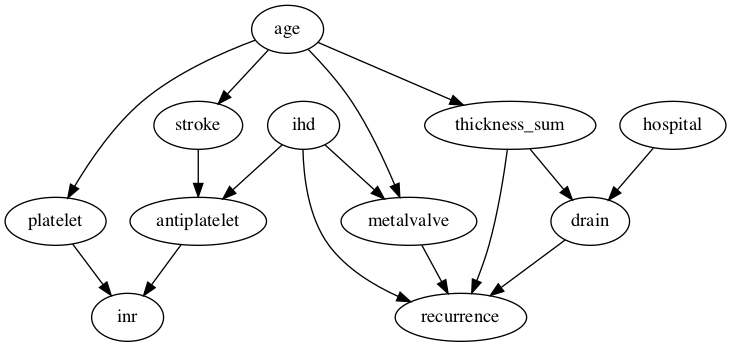

In [6]:
data_model = CausalModel(data=csdh, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/small_data_dag.dot'.replace("\n", " "))
data_model.view_model()
display(Image(filename="causal_model.png"))

---
## Define set of classifiers to investigate

In [7]:
names = ['Dummy', 'LR', 'Linear SVM', 'RBF SVM', 'GB', 'RF', 'XGB']

In [8]:
# Naive Bayes exluded due to mixture of variable types
classifiers = [
    DummyClassifier(strategy='most_frequent'),
    LogisticRegression(max_iter=1000),
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    XGBClassifier(random_state=random_state),
]

# _Double Machine Learning:_ finding `model_y` and `model_t`.
- `model_y` models $\mathbb{E}[Y \mid X,W]$ where the treatment variable $T$ is omitted from the covariates
- `model_t` is the propensity model and involves estimating $P[T=1\mid X,W]$

In [9]:
y_rec_full = csdh_data['recurrence']
X_rec_full = csdh_data.drop(['drain', 'recurrence'], axis=1)

In [10]:
# Split into validation set and rest
X_rec_rest, X_rec_val, y_rec_rest, y_rec_val = train_test_split(X_rec_full, y_rec_full, 
                                                                test_size=0.20,
                                                                random_state=random_state,
                                                                stratify=y_rec_full)

# Split rest into train and test set
X_rec_train, X_rec_test, y_rec_train, y_rec_test = train_test_split(X_rec_rest, y_rec_rest, 
                                                                    test_size=0.20,
                                                                    random_state=random_state,
                                                                    stratify=y_rec_rest)

In [11]:
rec_training_scores, rec_val_scores = mmh.train_and_validate_classifiers(X_rec_train, 
                                                                         y_rec_train,
                                                                         X_rec_val,
                                                                         y_rec_val,
                                                                         names,
                                                                         classifiers)

[15:23:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [12]:
mmh.print_metrics_table(rec_training_scores, rec_val_scores, names)

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑   AUROC↑  Recall↑      F1↑      LL↓     Acc↑   AUROC↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.906    0.500    0.000    0.000   3.245    0.908    0.500    0.000    0.000    3.193
LR            0.906    0.500    0.000    0.000   3.245    0.908    0.500    0.000    0.000    3.193
Linear SVM    0.906    0.500    0.000    0.000   3.245    0.908    0.500    0.000    0.000    3.193
RBF SVM       0.906    0.500    0.000    0.000   3.245    0.908    0.500    0.000    0.000    3.193
GB            0.879    0.485    0.000    0.000   4.172    0.960    0.784    0.568    0.725    1.379
RF            0.893    0.493    0.000    0.000   3.709    1.000    1.000    1.000    1.000    0.000
XGB           0.886    0.521    0.071    0.105 

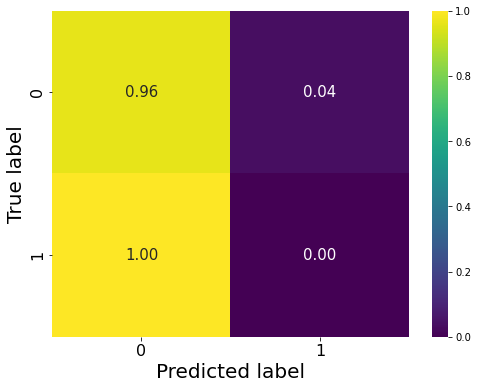

In [13]:
cm_rec_test = confusion_matrix(y_rec_test, classifiers[4].predict(X_rec_test), normalize='true')
mmh.plot_confusion_matrix(cm_rec_test, [0, 1])

## `model_y` K-Fold cross validation for hyperparameter tuning and model selection

In [14]:
# define cross-validation structure
cv_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

In [15]:
# define classifiers and hyperparameters to search over
rf = RandomForestClassifier()
params_rf = {
    # randomly sample numbers from 10 to 200 estimators
    'rf__n_estimators':randint(10, 200),
    
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'rf__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'rf__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators.
    
    'rf__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'rf__max_features':['sqrt', 'log2', None],
    # random seed
    'rf__random_state':[random_state],
    # Whether bootstrap samples are used when building trees
    'rf__bootstrap':[True, False]
}

gb = GradientBoostingClassifier()
params_gb = {
    # randomly sample numbers from 10 to 200 estimators
    'gb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'gb__subsample':[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1],
    # learning rate
    'gb__learning_rate':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1.0],
        
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    
    'gb__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'gb__max_features':['sqrt', 'log2', None],
    # random seed
    'gb__random_state':[random_state]
}

xgb = XGBClassifier()
params_xgb = {
    # randomly sample numbers from 10 to 200 estimators
    'xgb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'xgb__subsample':[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1],
    # learning rate
    'xgb__learning_rate':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1],
    # min_split_loss
    'xgb__gamma':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3],
 
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    
    'xgb__max_depth':randint(2, 15),
    # analagous to max_features in rf and gb
    'xgb__colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1],
    # random seed
    'xgb__random_state':[random_state],
}

In [16]:
# define search spaces for random search tuning
search_space = [('rf', rf, params_rf), ('gb', gb, params_gb), ('xgb', xgb, params_xgb)]

In [ ]:
# do the search
_,_, best_estimator_rec = mmh.randomized_search_cv(X_rec_rest, y_rec_rest, 
                                                   search_space, 
                                                   cv=cv_10,
                                                   refit=True,
                                                   n_iter=5000, 
                                                   verbose=True)

cv strategy StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'xgb__n_estimators': 136, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=136,
                               n_jobs=None, num_parallel

cv score: [0.61818182 0.42592593 0.62345679 0.75617284 0.4382716  0.53395062
 0.4        0.55925926 0.54074074 0.41481481]
----------------------------------------
Trial 11
----------------------------------------
Parameters {'gb__n_estimators': 139, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            n_estimators=139, random_state=100,
                                            subsample=0.95))])
cv score: [0.66545455 0.41049383 0.62191358 0.66666667 0.62654321 0.51234568
 0.36296296 0.23518519 0.54814815 0.51666667]
----------------------------------------
Trial 12
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[(

cv score: [0.60363636 0.5941358  0.49691358 0.68209877 0.45679012 0.54012346
 0.58518519 0.37037037 0.63148148 0.63703704]
----------------------------------------
Trial 22
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features=None,
                                        n_estimators=104, random_state=100))])
cv score: [0.62545455 0.40432099 0.63271605 0.84876543 0.63888889 0.58950617
 0.39259259 0.37777778 0.47777778 0.4962963 ]
----------------------------------------
Trial 23
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(b

cv score: [0.6        0.33024691 0.37962963 0.73148148 0.83641975 0.38580247
 0.31851852 0.3037037  0.59259259 0.63703704]
----------------------------------------
Trial 32
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                            n_estimators=128, random_state=100,
                                            subsample=0.7))])
cv score: [0.73090909 0.44135802 0.62654321 0.69444444 0.44753086 0.25
 0.26666667 0.2        0.74074074 0.48888889]
----------------------------------------
Trial 33
----------------------------------------
Parameters {'gb__n_estimators': 95, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: P

cv score: [0.81090909 0.47222222 0.67283951 0.65740741 0.41049383 0.44753086
 0.45925926 0.39259259 0.55185185 0.48148148]
----------------------------------------
Trial 43
----------------------------------------
Parameters {'xgb__n_estimators': 176, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=176,
  

cv score: [0.62727273 0.44444444 0.64969136 0.84876543 0.64969136 0.52623457
 0.35740741 0.40925926 0.5        0.56666667]
----------------------------------------
Trial 53
----------------------------------------
Parameters {'rf__n_estimators': 188, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=188, random_state=100))])
cv score: [0.67636364 0.44444444 0.59259259 0.78395062 0.72222222 0.56481481
 0.38518519 0.35185185 0.58148148 0.48518519]
----------------------------------------
Trial 54
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.

cv score: [0.73090909 0.46296296 0.50925926 0.66975309 0.54938272 0.46296296
 0.33333333 0.44444444 0.53333333 0.36296296]
----------------------------------------
Trial 64
----------------------------------------
Parameters {'xgb__n_estimators': 103, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=103,
       

cv score: [0.66545455 0.33641975 0.69753086 0.77469136 0.67901235 0.51851852
 0.37037037 0.26666667 0.54074074 0.56296296]
----------------------------------------
Trial 74
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=69, random_state=100))])
cv score: [0.70181818 0.51234568 0.62654321 0.78703704 0.70061728 0.44753086
 0.30740741 0.3962963  0.46296296 0.48148148]
----------------------------------------
Trial 75
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                

cv score: [0.65454545 0.58179012 0.43364198 0.68055556 0.52314815 0.57098765
 0.60740741 0.27592593 0.5037037  0.5037037 ]
----------------------------------------
Trial 84
----------------------------------------
Parameters {'xgb__n_estimators': 142, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=142,
   

cv score: [0.71636364 0.41358025 0.46296296 0.56790123 0.60185185 0.34259259
 0.38888889 0.36296296 0.61111111 0.47777778]
----------------------------------------
Trial 92
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            n_estimators=147, random_state=100,
                                            subsample=0.95))])
cv score: [0.71636364 0.44444444 0.64197531 0.73765432 0.70061728 0.60802469
 0.38518519 0.16296296 0.58518519 0.6       ]
----------------------------------------
Trial 93
----------------------------------------
Parameters {'xgb__n_estimators': 59, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6,

cv score: [0.72       0.46296296 0.55246914 0.79320988 0.5308642  0.46296296
 0.27777778 0.4037037  0.45925926 0.50740741]
----------------------------------------
Trial 102
----------------------------------------
Parameters {'rf__n_estimators': 47, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=47, random_state=100))])
cv score: [0.58909091 0.52777778 0.57716049 0.67283951 0.57098765 0.4691358
 0.4037037  0.35555556 0.51851852 0.61851852]
----------------------------------------
Trial 103
----------------------------------------
Parameters {'xgb__n_estimators': 160, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base

cv score: [0.73454545 0.47530864 0.66975309 0.63580247 0.63580247 0.52777778
 0.37037037 0.34814815 0.5        0.4962963 ]
----------------------------------------
Trial 113
----------------------------------------
Parameters {'rf__n_estimators': 32, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=32, random_state=100))])
cv score: [0.77636364 0.70679012 0.45987654 0.63117284 0.47839506 0.54938272
 0.49074074 0.31666667 0.32037037 0.43703704]
----------------------------------------
Trial 114
----------------------------------------
Parameters {'gb__n_estimators': 107, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, 

cv score: [0.64363636 0.36728395 0.57407407 0.67283951 0.59567901 0.5462963
 0.4037037  0.27777778 0.58518519 0.55925926]
----------------------------------------
Trial 123
----------------------------------------
Parameters {'gb__n_estimators': 114, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=114, random_state=100,
                                            subsample=0.85))])
cv score: [0.50909091 0.49382716 0.58333333 0.55246914 0.64506173 0.34567901
 0.63703704 0.35555556 0.47777778 0.45185185]
----------------------------------------
Trial 124
----------------------------------------
Parameters {'xgb__n_estimators': 174, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb_

cv score: [0.61090909 0.41975309 0.51234568 0.6882716  0.59567901 0.50617284
 0.46666667 0.26296296 0.55925926 0.57407407]
----------------------------------------
Trial 133
----------------------------------------
Parameters {'gb__n_estimators': 193, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7,
                                            max_features='sqrt',
                                            n_estimators=193, random_state=100,
                                            subsample=0.65))])
cv score: [0.70545455 0.40432099 0.65432099 0.37808642 0.58950617 0.35802469
 0.44074074 0.47592593 0.48148148 0.22592593]
----------------------------------------
Trial 134
----------------------------------------
Parameters {'rf__n_estimators': 48, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 10

cv score: [0.59272727 0.54320988 0.52006173 0.72530864 0.50925926 0.57407407
 0.5037037  0.34074074 0.61481481 0.53333333]
----------------------------------------
Trial 145
----------------------------------------
Parameters {'rf__n_estimators': 72, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=72, random_state=100))])
cv score: [0.71636364 0.37345679 0.625      0.83950617 0.7037037  0.5617284
 0.2962963  0.38888889 0.5962963  0.5       ]
----------------------------------------
Trial 146
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
          

cv score: [0.56       0.55092593 0.49691358 0.56944444 0.55246914 0.58024691
 0.52962963 0.29074074 0.60185185 0.50185185]
----------------------------------------
Trial 156
----------------------------------------
Parameters {'gb__n_estimators': 171, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                                            max_features='log2',
                                            n_estimators=171, random_state=100,
                                            subsample=0.6))])
cv score: [0.54909091 0.4691358  0.68209877 0.74074074 0.66975309 0.43518519
 0.38148148 0.41111111 0.48888889 0.46296296]
----------------------------------------
Trial 157
----------------------------------------
Parameters {'gb__n_estimators': 32, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__m

cv score: [0.65454545 0.35185185 0.50308642 0.66358025 0.71604938 0.4537037
 0.2962963  0.41851852 0.44814815 0.61851852]
----------------------------------------
Trial 169
----------------------------------------
Parameters {'gb__n_estimators': 79, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=79, random_state=100,
                                            subsample=0.8))])
cv score: [0.79272727 0.44753086 0.5308642  0.69444444 0.59876543 0.4845679
 0.25185185 0.35925926 0.47777778 0.52222222]
----------------------------------------
Trial 170
----------------------------------------
Parameters {'rf__n_estimators': 151, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__rando

cv score: [0.81454545 0.46296296 0.68209877 0.69135802 0.50925926 0.39506173
 0.31851852 0.43333333 0.71851852 0.51851852]
----------------------------------------
Trial 180
----------------------------------------
Parameters {'gb__n_estimators': 196, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, n_estimators=196,
                                            random_state=100, subsample=0.9))])
cv score: [0.66545455 0.46296296 0.6882716  0.83641975 0.72530864 0.44135802
 0.4962963  0.42592593 0.55555556 0.5       ]
----------------------------------------
Trial 181
----------------------------------------
Parameters {'gb__n_estimators': 39, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingC

cv score: [0.82545455 0.46296296 0.44135802 0.76851852 0.60493827 0.48765432
 0.22962963 0.55185185 0.44814815 0.36296296]
----------------------------------------
Trial 188
----------------------------------------
Parameters {'gb__n_estimators': 88, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=10,
                                            n_estimators=88, random_state=100,
                                            subsample=0.75))])
cv score: [0.77454545 0.42592593 0.54012346 0.71296296 0.50617284 0.47222222
 0.28148148 0.61851852 0.4        0.52222222]
----------------------------------------
Trial 189
----------------------------------------
Parameters {'rf__n_estimators': 198, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf

cv score: [0.75272727 0.55246914 0.5617284  0.75617284 0.67283951 0.24382716
 0.26296296 0.2962963  0.76666667 0.61851852]
----------------------------------------
Trial 201
----------------------------------------
Parameters {'rf__n_estimators': 151, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=151,
                                        random_state=100))])
cv score: [0.70727273 0.51697531 0.57098765 0.66666667 0.60802469 0.50617284
 0.35555556 0.32592593 0.53888889 0.47037037]
----------------------------------------
Trial 202
----------------------------------------
Parameters {'rf__n_estimators': 94, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestC

cv score: [0.70909091 0.40432099 0.47839506 0.75       0.63271605 0.4691358
 0.31851852 0.58518519 0.50740741 0.37037037]
----------------------------------------
Trial 210
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=55,
   

cv score: [0.61454545 0.5154321  0.48148148 0.71296296 0.48765432 0.53395062
 0.47777778 0.34814815 0.54444444 0.56666667]
----------------------------------------
Trial 218
----------------------------------------
Parameters {'rf__n_estimators': 116, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=116, random_state=100))])
cv score: [0.69090909 0.4537037  0.59876543 0.7808642  0.66358025 0.53395062
 0.32962963 0.38518519 0.57777778 0.5       ]
----------------------------------------
Trial 219
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(b

cv score: [0.60727273 0.44444444 0.52777778 0.5462963  0.49382716 0.5617284
 0.62407407 0.2462963  0.48148148 0.56296296]
----------------------------------------
Trial 227
----------------------------------------
Parameters {'gb__n_estimators': 183, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            n_estimators=183, random_state=100,
                                            subsample=0.6))])
cv score: [0.64363636 0.41049383 0.62654321 0.77777778 0.62962963 0.50925926
 0.28148148 0.29259259 0.58518519 0.53703704]
----------------------------------------
Trial 228
----------------------------------------
Parameters {'rf__n_estimators': 140, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('

Parameters {'xgb__n_estimators': 18, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=18,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=100, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
             

cv score: [0.67272727 0.39197531 0.54320988 0.7345679  0.54938272 0.51851852
 0.48148148 0.30740741 0.62222222 0.55185185]
----------------------------------------
Trial 251
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=20,
       

cv score: [0.66545455 0.33024691 0.68209877 0.6882716  0.63271605 0.47839506
 0.37777778 0.30740741 0.58888889 0.6037037 ]
----------------------------------------
Trial 263
----------------------------------------
Parameters {'rf__n_estimators': 130, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=130, random_state=100))])
cv score: [0.76727273 0.61574074 0.52932099 0.6882716  0.49691358 0.54475309
 0.41111111 0.36666667 0.4537037  0.40740741]
----------------------------------------
Trial 264
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base

cv score: [0.60727273 0.25       0.66975309 0.65123457 0.55246914 0.55246914
 0.42962963 0.37037037 0.51851852 0.56666667]
----------------------------------------
Trial 272
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=151,
       

cv score: [0.64       0.34259259 0.58024691 0.69135802 0.59259259 0.56481481
 0.34814815 0.3        0.54814815 0.54444444]
----------------------------------------
Trial 282
----------------------------------------
Parameters {'xgb__n_estimators': 184, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=184,


cv score: [0.62545455 0.4537037  0.70987654 0.68518519 0.69753086 0.40740741
 0.18888889 0.57777778 0.61481481 0.42592593]
----------------------------------------
Trial 291
----------------------------------------
Parameters {'gb__n_estimators': 115, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
                                            n_estimators=115, random_state=100,
                                            subsample=0.75))])
cv score: [0.66545455 0.53395062 0.69444444 0.87654321 0.72222222 0.30246914
 0.43703704 0.40740741 0.37777778 0.42962963]
----------------------------------------
Trial 292
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8

cv score: [0.60727273 0.5154321  0.44444444 0.66358025 0.47222222 0.41049383
 0.31111111 0.28518519 0.47777778 0.5037037 ]
----------------------------------------
Trial 301
----------------------------------------
Parameters {'rf__n_estimators': 40, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=40,
                                        random_state=100))])
cv score: [0.72363636 0.41666667 0.77777778 0.61419753 0.56790123 0.4845679
 0.51111111 0.32592593 0.6037037  0.57037037]
----------------------------------------
Trial 302
----------------------------------------
Parameters {'xgb__n_estimators': 132, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: P

cv score: [0.54909091 0.54938272 0.60802469 0.49691358 0.49382716 0.51080247
 0.47222222 0.55925926 0.38888889 0.41481481]
----------------------------------------
Trial 312
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=24,
                                            random_state=100))])
cv score: [0.64727273 0.33641975 0.66049383 0.77469136 0.60802469 0.52777778
 0.43333333 0.24074074 0.49444444 0.52222222]
----------------------------------------
Trial 313
----------------------------------------
Parameters {'rf__n_estimators': 180, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100

cv score: [0.68       0.37037037 0.54012346 0.62191358 0.53395062 0.47222222
 0.52222222 0.3037037  0.58888889 0.55185185]
----------------------------------------
Trial 322
----------------------------------------
Parameters {'rf__n_estimators': 192, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=192,
                                        random_state=100))])
cv score: [0.70545455 0.39506173 0.63271605 0.6882716  0.64506173 0.53395062
 0.4        0.37777778 0.6        0.59259259]
----------------------------------------
Trial 323
----------------------------------------
Parameters {'rf__n_estimators': 113, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomFore

cv score: [0.67272727 0.50308642 0.4382716  0.6882716  0.54938272 0.39814815
 0.43703704 0.39814815 0.42222222 0.32222222]
----------------------------------------
Trial 333
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=14,


cv score: [0.59636364 0.38580247 0.5617284  0.72222222 0.53703704 0.53703704
 0.4962963  0.32962963 0.6        0.53333333]
----------------------------------------
Trial 342
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimators=45,
                                        random_state=100))])
cv score: [0.76       0.41049383 0.65740741 0.65740741 0.63888889 0.5
 0.4037037  0.27777778 0.69259259 0.70740741]
----------------------------------------
Trial 343
----------------------------------------
Parameters {'xgb__n_estimators': 47, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.73090909 0.35493827 0.59876543 0.74382716 0.64506173 0.49382716
 0.35925926 0.41851852 0.3962963  0.45555556]
----------------------------------------
Trial 353
----------------------------------------
Parameters {'rf__n_estimators': 78, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=78, random_state=100))])
cv score: [0.76       0.66049383 0.63271605 0.68518519 0.57098765 0.48765432
 0.47407407 0.26666667 0.42592593 0.44444444]
----------------------------------------
Trial 354
----------------------------------------
Parameters {'xgb__n_estimators': 123, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(b

cv score: [0.74909091 0.37654321 0.54012346 0.6882716  0.65432099 0.42592593
 0.34074074 0.42592593 0.5037037  0.45555556]
----------------------------------------
Trial 363
----------------------------------------
Parameters {'rf__n_estimators': 22, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=22,
                                        random_state=100))])
cv score: [0.69636364 0.5        0.49228395 0.65895062 0.58796296 0.52469136
 0.46851852 0.33148148 0.56296296 0.48148148]
----------------------------------------
Trial 364
----------------------------------------
Parameters {'rf__n_estimators': 181, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestCl

cv score: [0.72       0.37345679 0.59876543 0.65123457 0.58333333 0.48148148
 0.3        0.45185185 0.37777778 0.35555556]
----------------------------------------
Trial 372
----------------------------------------
Parameters {'gb__n_estimators': 173, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, max_features='log2',
                                            n_estimators=173, random_state=100,
                                            subsample=0.9))])
cv score: [0.77818182 0.41049383 0.67283951 0.7808642  0.65123457 0.35185185
 0.4037037  0.41111111 0.65555556 0.45925926]
----------------------------------------
Trial 373
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8,

cv score: [0.63636364 0.46604938 0.51851852 0.58333333 0.58950617 0.4691358
 0.39259259 0.33703704 0.57777778 0.53703704]
----------------------------------------
Trial 383
----------------------------------------
Parameters {'xgb__n_estimators': 36, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=36,
     

cv score: [0.76       0.38888889 0.60185185 0.74382716 0.61111111 0.48148148
 0.37037037 0.45185185 0.51481481 0.35925926]
----------------------------------------
Trial 391
----------------------------------------
Parameters {'gb__n_estimators': 84, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=11,
                                            n_estimators=84,
                                            random_state=100))])
cv score: [0.58       0.47530864 0.72530864 0.49845679 0.61574074 0.51697531
 0.42407407 0.34259259 0.41481481 0.61851852]
----------------------------------------
Trial 392
----------------------------------------
Parameters {'xgb__n_estimators': 143, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_sta

cv score: [0.66181818 0.35493827 0.69753086 0.7191358  0.63271605 0.5
 0.4        0.33703704 0.63333333 0.64074074]
----------------------------------------
Trial 400
----------------------------------------
Parameters {'xgb__n_estimators': 78, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=78,
         

cv score: [0.6        0.47530864 0.70833333 0.57407407 0.63734568 0.55555556
 0.59814815 0.45555556 0.41481481 0.60740741]
----------------------------------------
Trial 411
----------------------------------------
Parameters {'gb__n_estimators': 100, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='log2',
                                            random_state=100, subsample=0.7))])
cv score: [0.59272727 0.44135802 0.65432099 0.58950617 0.67901235 0.50925926
 0.4        0.41851852 0.32592593 0.34814815]
----------------------------------------
Trial 412
----------------------------------------
Parameters {'rf__n_estimators': 31, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=

cv score: [0.66909091 0.47222222 0.44444444 0.58950617 0.48148148 0.4691358
 0.45185185 0.38148148 0.6        0.46666667]
----------------------------------------
Trial 423
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=141,
       

cv score: [0.77454545 0.38271605 0.60493827 0.80246914 0.62345679 0.48148148
 0.35555556 0.61111111 0.58148148 0.4       ]
----------------------------------------
Trial 433
----------------------------------------
Parameters {'xgb__n_estimators': 116, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=5, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=116,
 

cv score: [0.70545455 0.41666667 0.52160494 0.7654321  0.5462963  0.42901235
 0.32592593 0.38888889 0.54444444 0.38148148]
----------------------------------------
Trial 441
----------------------------------------
Parameters {'xgb__n_estimators': 54, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=54,
    

cv score: [0.62545455 0.49382716 0.6882716  0.71296296 0.56790123 0.48148148
 0.3962963  0.41111111 0.35185185 0.34814815]
----------------------------------------
Trial 451
----------------------------------------
Parameters {'gb__n_estimators': 157, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='log2',
                                            n_estimators=157,
                                            random_state=100))])
cv score: [0.69818182 0.46604938 0.65123457 0.78703704 0.70987654 0.39814815
 0.37407407 0.37407407 0.51111111 0.35555556]
----------------------------------------
Trial 452
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf

cv score: [0.61818182 0.2808642  0.55864198 0.61111111 0.60185185 0.55246914
 0.42222222 0.24074074 0.60740741 0.5037037 ]
----------------------------------------
Trial 461
----------------------------------------
Parameters {'xgb__n_estimators': 117, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=117,
  

cv score: [0.54545455 0.58024691 0.48611111 0.68518519 0.45061728 0.52469136
 0.56851852 0.43148148 0.62407407 0.54444444]
----------------------------------------
Trial 470
----------------------------------------
Parameters {'xgb__n_estimators': 191, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=191,
    

cv score: [0.61454545 0.51851852 0.70061728 0.63271605 0.44135802 0.25925926
 0.56296296 0.53703704 0.38518519 0.22222222]
----------------------------------------
Trial 480
----------------------------------------
Parameters {'rf__n_estimators': 11, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=11,
                                        random_state=100))])
cv score: [0.6        0.47530864 0.71141975 0.57407407 0.63734568 0.56018519
 0.59814815 0.45185185 0.41481481 0.60555556]
----------------------------------------
Trial 481
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline:

cv score: [0.59090909 0.46296296 0.52006173 0.5462963  0.54938272 0.48765432
 0.57222222 0.3        0.62962963 0.49444444]
----------------------------------------
Trial 489
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=118,
                                        random_state=100))])
cv score: [0.73636364 0.54166667 0.56790123 0.68518519 0.60339506 0.49074074
 0.47037037 0.32962963 0.52592593 0.52407407]
----------------------------------------
Trial 490
----------------------------------------
Parameters {'gb__n_estimators': 183, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
    

cv score: [0.66545455 0.32716049 0.54320988 0.66666667 0.60185185 0.5154321
 0.27407407 0.41851852 0.47037037 0.37407407]
----------------------------------------
Trial 497
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,
                                            max_features='sqrt',
                                            n_estimators=91,
                                            random_state=100))])
cv score: [0.71090909 0.56790123 0.51080247 0.65277778 0.6404321  0.56790123
 0.37037037 0.26296296 0.51666667 0.5       ]
----------------------------------------
Trial 498
----------------------------------------
Parameters {'xgb__n_estimators': 133, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_dep

cv score: [0.8        0.49382716 0.52160494 0.72530864 0.56790123 0.48148148
 0.52222222 0.47777778 0.51111111 0.31481481]
----------------------------------------
Trial 506
----------------------------------------
Parameters {'rf__n_estimators': 13, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=13,
                                        random_state=100))])
cv score: [0.62727273 0.32561728 0.59876543 0.66666667 0.61265432 0.42283951
 0.29074074 0.27962963 0.65185185 0.58148148]
----------------------------------------
Trial 507
----------------------------------------
Parameters {'xgb__n_estimators': 180, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline:

cv score: [0.57090909 0.42283951 0.53703704 0.86111111 0.45987654 0.42283951
 0.54444444 0.58148148 0.5962963  0.43333333]
----------------------------------------
Trial 516
----------------------------------------
Parameters {'xgb__n_estimators': 112, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=112,
   

cv score: [0.54909091 0.60185185 0.69444444 0.89814815 0.66666667 0.37654321
 0.41481481 0.42222222 0.62222222 0.41481481]
----------------------------------------
Trial 524
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=54, random_state=100))])
cv score: [0.66545455 0.45061728 0.65740741 0.80864198 0.63580247 0.57716049
 0.34444444 0.30740741 0.5037037  0.51111111]
----------------------------------------
Trial 525
----------------------------------------
Parameters {'xgb__n_estimators': 171, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base

cv score: [0.80181818 0.58179012 0.59567901 0.66358025 0.63734568 0.52932099
 0.52222222 0.42037037 0.55       0.47962963]
----------------------------------------
Trial 534
----------------------------------------
Parameters {'rf__n_estimators': 179, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=179, random_state=100))])
cv score: [0.67636364 0.5154321  0.58641975 0.62037037 0.61419753 0.55555556
 0.4037037  0.31111111 0.54074074 0.44074074]
----------------------------------------
Trial 535
----------------------------------------
Parameters {'xgb__n_estimators': 53, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(bas

cv score: [0.83636364 0.38580247 0.54320988 0.77777778 0.5308642  0.45679012
 0.32222222 0.48518519 0.36296296 0.42222222]
----------------------------------------
Trial 544
----------------------------------------
Parameters {'rf__n_estimators': 25, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=25,
                                        random_state=100))])
cv score: [0.74909091 0.41666667 0.57407407 0.70061728 0.55555556 0.5308642
 0.40740741 0.43703704 0.56666667 0.57777778]
----------------------------------------
Trial 545
----------------------------------------
Parameters {'xgb__n_estimators': 18, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline

cv score: [0.78181818 0.38580247 0.56481481 0.59259259 0.64506173 0.55246914
 0.36296296 0.43333333 0.44814815 0.47037037]
----------------------------------------
Trial 554
----------------------------------------
Parameters {'gb__n_estimators': 69, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                            n_estimators=69, random_state=100,
                                            subsample=0.8))])
cv score: [0.74909091 0.49382716 0.58641975 0.69444444 0.69444444 0.50925926
 0.37037037 0.30555556 0.52777778 0.46666667]
----------------------------------------
Trial 555
----------------------------------------
Parameters {'xgb__n_estimators': 184, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb_

cv score: [0.60909091 0.37962963 0.70679012 0.50771605 0.81944444 0.57253086
 0.51111111 0.34814815 0.4962963  0.60555556]
----------------------------------------
Trial 564
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=91,
                                        random_state=100))])
cv score: [0.75454545 0.56635802 0.55864198 0.67901235 0.63425926 0.49382716
 0.5037037  0.32777778 0.52222222 0.51111111]
----------------------------------------
Trial 565
----------------------------------------
Parameters {'xgb__n_estimators': 160, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline:

cv score: [0.62545455 0.47222222 0.54938272 0.69135802 0.41666667 0.45216049
 0.52592593 0.25925926 0.5037037  0.51481481]
----------------------------------------
Trial 573
----------------------------------------
Parameters {'gb__n_estimators': 90, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                            max_features='log2',
                                            n_estimators=90, random_state=100,
                                            subsample=0.8))])
cv score: [0.58545455 0.38580247 0.54320988 0.71296296 0.52469136 0.45987654
 0.61111111 0.5        0.17037037 0.4037037 ]
----------------------------------------
Trial 574
----------------------------------------
Parameters {'rf__n_estimators': 123, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_s

cv score: [0.76727273 0.37962963 0.81481481 0.69444444 0.62962963 0.61419753
 0.40740741 0.55925926 0.50740741 0.32222222]
----------------------------------------
Trial 585
----------------------------------------
Parameters {'gb__n_estimators': 30, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='log2',
                                            n_estimators=30, random_state=100,
                                            subsample=0.8))])
cv score: [0.76363636 0.41975309 0.66049383 0.73148148 0.55864198 0.56481481
 0.28148148 0.27407407 0.58518519 0.53703704]
----------------------------------------
Trial 586
----------------------------------------
Parameters {'xgb__n_estimators': 195, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__

cv score: [0.66909091 0.37037037 0.45987654 0.62962963 0.5        0.39506173
 0.25185185 0.39259259 0.52592593 0.45185185]
----------------------------------------
Trial 594
----------------------------------------
Parameters {'xgb__n_estimators': 78, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=78,
         

cv score: [0.60545455 0.52469136 0.5154321  0.52469136 0.49382716 0.54938272
 0.62037037 0.28333333 0.59444444 0.60555556]
----------------------------------------
Trial 604
----------------------------------------
Parameters {'xgb__n_estimators': 88, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=13, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=88,


cv score: [0.74181818 0.39506173 0.41975309 0.70987654 0.46296296 0.5154321
 0.30740741 0.4        0.46666667 0.43333333]
----------------------------------------
Trial 615
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=118,
     

cv score: [0.63636364 0.38271605 0.57098765 0.7191358  0.56481481 0.57716049
 0.43703704 0.32222222 0.62222222 0.58888889]
----------------------------------------
Trial 624
----------------------------------------
Parameters {'xgb__n_estimators': 199, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=199,
 

cv score: [0.63818182 0.41666667 0.5308642  0.54012346 0.40740741 0.5308642
 0.58703704 0.48888889 0.60555556 0.50555556]
----------------------------------------
Trial 634
----------------------------------------
Parameters {'gb__n_estimators': 103, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            n_estimators=103, random_state=100,
                                            subsample=0.8))])
cv score: [0.72       0.41049383 0.66358025 0.69135802 0.66358025 0.54938272
 0.29259259 0.26296296 0.57037037 0.51111111]
----------------------------------------
Trial 635
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('r

cv score: [0.66363636 0.59722222 0.62037037 0.45987654 0.62962963 0.52932099
 0.52222222 0.25740741 0.37962963 0.8537037 ]
----------------------------------------
Trial 646
----------------------------------------
Parameters {'gb__n_estimators': 89, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=89, random_state=100,
                                            subsample=0.75))])
cv score: [0.72363636 0.33641975 0.74382716 0.71604938 0.74382716 0.55555556
 0.3962963  0.36666667 0.52962963 0.52962963]
----------------------------------------
Trial 647
----------------------------------------
Parameters {'gb__n_estimators': 78, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__

cv score: [0.68727273 0.57098765 0.62345679 0.66049383 0.55246914 0.67283951
 0.34444444 0.2037037  0.52222222 0.55555556]
----------------------------------------
Trial 657
----------------------------------------
Parameters {'xgb__n_estimators': 70, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=70,
     

cv score: [0.72727273 0.37654321 0.62962963 0.82407407 0.67283951 0.57098765
 0.36296296 0.36481481 0.55925926 0.51481481]
----------------------------------------
Trial 667
----------------------------------------
Parameters {'gb__n_estimators': 19, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, max_features='log2',
                                            n_estimators=19, random_state=100,
                                            subsample=0.8))])
cv score: [0.83636364 0.50925926 0.64506173 0.65740741 0.58641975 0.54938272
 0.28148148 0.33703704 0.41481481 0.47777778]
----------------------------------------
Trial 668
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pi

cv score: [0.77454545 0.37345679 0.52777778 0.64814815 0.58950617 0.55864198
 0.32962963 0.3        0.46296296 0.54444444]
----------------------------------------
Trial 677
----------------------------------------
Parameters {'xgb__n_estimators': 94, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=94,
   

cv score: [0.70545455 0.32098765 0.64814815 0.7654321  0.75       0.5
 0.37407407 0.4        0.58888889 0.55925926]
----------------------------------------
Trial 687
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=74, random_state=100))])
cv score: [0.72       0.45679012 0.62037037 0.83333333 0.64197531 0.48148148
 0.36666667 0.44074074 0.61111111 0.46296296]
----------------------------------------
Trial 688
----------------------------------------
Parameters {'rf__n_estimators': 152, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                  

cv score: [0.62545455 0.37037037 0.68209877 0.77160494 0.6882716  0.50308642
 0.41481481 0.35555556 0.53333333 0.54814815]
----------------------------------------
Trial 697
----------------------------------------
Parameters {'rf__n_estimators': 179, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=179, random_state=100))])
cv score: [0.65454545 0.40123457 0.54320988 0.74691358 0.69444444 0.47839506
 0.36296296 0.42592593 0.54074074 0.42222222]
----------------------------------------
Trial 698
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
              

cv score: [0.77454545 0.39197531 0.59876543 0.61419753 0.59876543 0.37345679
 0.25185185 0.37037037 0.58148148 0.5037037 ]
----------------------------------------
Trial 709
----------------------------------------
Parameters {'gb__n_estimators': 105, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=12,
                                            n_estimators=105, random_state=100,
                                            subsample=0.7))])
cv score: [0.72       0.4382716  0.7345679  0.78395062 0.75       0.43518519
 0.37777778 0.40740741 0.45925926 0.44814815]
----------------------------------------
Trial 710
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}

cv score: [0.68363636 0.34259259 0.50308642 0.67283951 0.4691358  0.45987654
 0.27407407 0.33333333 0.56296296 0.46296296]
----------------------------------------
Trial 719
----------------------------------------
Parameters {'gb__n_estimators': 33, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            max_features='log2',
                                            n_estimators=33,
                                            random_state=100))])
cv score: [0.59272727 0.34567901 0.68518519 0.76234568 0.66975309 0.64814815
 0.44074074 0.34444444 0.64074074 0.58888889]
----------------------------------------
Trial 720
----------------------------------------
Parameters {'rf__n_estimators': 148, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 1

cv score: [0.69454545 0.51851852 0.5617284  0.6882716  0.58641975 0.50617284
 0.51111111 0.51111111 0.37407407 0.38518519]
----------------------------------------
Trial 729
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=20, random_state=100))])
cv score: [0.58727273 0.6095679  0.49537037 0.5617284  0.58487654 0.45216049
 0.63148148 0.20925926 0.54814815 0.32407407]
----------------------------------------
Trial 730
----------------------------------------
Parameters {'rf__n_estimators': 21, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                 

cv score: [0.64       0.58024691 0.36419753 0.77469136 0.53395062 0.3117284
 0.2962963  0.42592593 0.5037037  0.67037037]
----------------------------------------
Trial 740
----------------------------------------
Parameters {'gb__n_estimators': 90, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                            n_estimators=90, random_state=100,
                                            subsample=0.6))])
cv score: [0.50545455 0.47839506 0.59567901 0.5617284  0.61728395 0.37654321
 0.37407407 0.41111111 0.56666667 0.4037037 ]
----------------------------------------
Trial 741
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__

cv score: [0.64727273 0.45679012 0.63580247 0.75925926 0.61728395 0.60185185
 0.35185185 0.25185185 0.55185185 0.54814815]
----------------------------------------
Trial 749
----------------------------------------
Parameters {'xgb__n_estimators': 139, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=139,
 

cv score: [0.71454545 0.5787037  0.43055556 0.47222222 0.51851852 0.54012346
 0.52222222 0.17592593 0.49444444 0.52592593]
----------------------------------------
Trial 758
----------------------------------------
Parameters {'rf__n_estimators': 121, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=121,
                                        random_state=100))])
cv score: [0.65454545 0.51851852 0.37962963 0.47222222 0.50925926 0.47685185
 0.5        0.46296296 0.47222222 0.46481481]
----------------------------------------
Trial 759
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
       

cv score: [0.50545455 0.43209877 0.6882716  0.4382716  0.85339506 0.35802469
 0.40740741 0.4        0.53333333 0.5037037 ]
----------------------------------------
Trial 771
----------------------------------------
Parameters {'gb__n_estimators': 83, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            n_estimators=83, random_state=100,
                                            subsample=0.6))])
cv score: [0.49818182 0.4537037  0.70061728 0.72530864 0.70061728 0.63271605
 0.38148148 0.36666667 0.46666667 0.47407407]
----------------------------------------
Trial 772
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
P

cv score: [0.66727273 0.45061728 0.55864198 0.73148148 0.56944444 0.54166667
 0.4462963  0.27592593 0.55925926 0.55740741]
----------------------------------------
Trial 781
----------------------------------------
Parameters {'gb__n_estimators': 183, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, max_features='log2',
                                            n_estimators=183, random_state=100,
                                            subsample=0.75))])
cv score: [0.63272727 0.41975309 0.69753086 0.82716049 0.70679012 0.49382716
 0.45185185 0.41851852 0.42592593 0.41481481]
----------------------------------------
Trial 782
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 9, 'xgb__colsample_bytree':

cv score: [0.61090909 0.3117284  0.51234568 0.65432099 0.66666667 0.47530864
 0.25185185 0.28518519 0.54814815 0.45925926]
----------------------------------------
Trial 790
----------------------------------------
Parameters {'gb__n_estimators': 144, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=144,
                                            random_state=100))])
cv score: [0.67636364 0.41666667 0.68209877 0.79938272 0.76234568 0.39814815
 0.34444444 0.41111111 0.54074074 0.44074074]
----------------------------------------
Trial 791
----------------------------------------
Parameters {'gb__n_estimators': 52, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 14, 'gb_

cv score: [0.72727273 0.45061728 0.63271605 0.7962963  0.59259259 0.47839506
 0.34814815 0.42962963 0.45555556 0.47777778]
----------------------------------------
Trial 801
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=122,
    

cv score: [0.57636364 0.49074074 0.53240741 0.5462963  0.54783951 0.53240741
 0.66111111 0.32592593 0.56666667 0.43333333]
----------------------------------------
Trial 809
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, n_estimators=76,
                                            random_state=100, subsample=0.8))])
cv score: [0.58545455 0.48148148 0.7345679  0.84567901 0.7962963  0.58641975
 0.4037037  0.3962963  0.53703704 0.52592593]
----------------------------------------
Trial 810
----------------------------------------
Parameters {'xgb__n_estimators': 161, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
        

cv score: [0.70181818 0.41358025 0.63580247 0.8117284  0.65740741 0.56790123
 0.35555556 0.34444444 0.52222222 0.56296296]
----------------------------------------
Trial 818
----------------------------------------
Parameters {'rf__n_estimators': 129, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=129, random_state=100))])
cv score: [0.69090909 0.41358025 0.65123457 0.85802469 0.67283951 0.58641975
 0.33703704 0.42592593 0.50740741 0.4962963 ]
----------------------------------------
Trial 819
----------------------------------------
Parameters {'rf__n_estimators': 87, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
             

cv score: [0.72363636 0.45061728 0.5462963  0.77469136 0.52160494 0.4845679
 0.4037037  0.49259259 0.59259259 0.38148148]
----------------------------------------
Trial 829
----------------------------------------
Parameters {'rf__n_estimators': 59, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=59, random_state=100))])
cv score: [0.67272727 0.46604938 0.59259259 0.7962963  0.6882716  0.40740741
 0.38518519 0.37037037 0.49259259 0.52592593]
----------------------------------------
Trial 830
----------------------------------------
Parameters {'rf__n_estimators': 11, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                   

cv score: [0.75636364 0.36419753 0.55864198 0.66358025 0.60802469 0.50617284
 0.33333333 0.35185185 0.54074074 0.47777778]
----------------------------------------
Trial 840
----------------------------------------
Parameters {'xgb__n_estimators': 92, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=92,
      

cv score: [0.8        0.43209877 0.45061728 0.83024691 0.53703704 0.44753086
 0.48148148 0.44444444 0.43333333 0.37037037]
----------------------------------------
Trial 851
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=118,
                                        random_state=100))])
cv score: [0.64       0.51080247 0.70216049 0.47839506 0.69753086 0.47685185
 0.52037037 0.32777778 0.41666667 0.69074074]
----------------------------------------
Trial 852
----------------------------------------
Parameters {'xgb__n_estimators': 120, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipelin

cv score: [0.61090909 0.46759259 0.53395062 0.54012346 0.5462963  0.55092593
 0.61666667 0.48518519 0.66481481 0.46481481]
----------------------------------------
Trial 861
----------------------------------------
Parameters {'xgb__n_estimators': 88, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=88,
  

cv score: [0.68727273 0.5462963  0.42283951 0.7037037  0.56481481 0.49691358
 0.44814815 0.42962963 0.4962963  0.27037037]
----------------------------------------
Trial 870
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=101,
   

cv score: [0.74909091 0.2962963  0.52160494 0.78395062 0.39814815 0.49382716
 0.34074074 0.51111111 0.35555556 0.55185185]
----------------------------------------
Trial 879
----------------------------------------
Parameters {'xgb__n_estimators': 129, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=12

cv score: [0.65636364 0.41666667 0.55246914 0.5462963  0.59104938 0.52777778
 0.64444444 0.31481481 0.62962963 0.48333333]
----------------------------------------
Trial 888
----------------------------------------
Parameters {'xgb__n_estimators': 70, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=70,
 

cv score: [0.67636364 0.30864198 0.58333333 0.6882716  0.5617284  0.49074074
 0.4        0.21851852 0.6        0.53703704]
----------------------------------------
Trial 899
----------------------------------------
Parameters {'xgb__n_estimators': 182, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=182,
   

cv score: [0.56363636 0.45679012 0.49074074 0.67901235 0.47222222 0.52160494
 0.2962963  0.41481481 0.61481481 0.4037037 ]
----------------------------------------
Trial 908
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=185, random_state=100,
                                            subsample=0.7))])
cv score: [0.64727273 0.33950617 0.66358025 0.80246914 0.64197531 0.57407407
 0.44814815 0.41481481 0.4        0.45925926]
----------------------------------------
Trial 909
----------------------------------------
Parameters {'xgb__n_estimators': 117, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb_

cv score: [0.78181818 0.61265432 0.49228395 0.64814815 0.47222222 0.50154321
 0.51111111 0.29814815 0.45555556 0.39074074]
----------------------------------------
Trial 918
----------------------------------------
Parameters {'rf__n_estimators': 18, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=18, random_state=100))])
cv score: [0.58545455 0.41049383 0.60802469 0.68209877 0.66049383 0.42592593
 0.32592593 0.38518519 0.52592593 0.42592593]
----------------------------------------
Trial 919
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(b

cv score: [0.76363636 0.37962963 0.59876543 0.73765432 0.69135802 0.49691358
 0.36296296 0.42222222 0.54444444 0.46666667]
----------------------------------------
Trial 927
----------------------------------------
Parameters {'gb__n_estimators': 49, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            n_estimators=49, random_state=100,
                                            subsample=0.65))])
cv score: [0.75272727 0.38271605 0.5308642  0.65432099 0.75925926 0.48148148
 0.58888889 0.48888889 0.48148148 0.48703704]
----------------------------------------
Trial 928
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xg

cv score: [0.68545455 0.56790123 0.50154321 0.68364198 0.51851852 0.54783951
 0.61851852 0.31851852 0.65555556 0.50740741]
----------------------------------------
Trial 936
----------------------------------------
Parameters {'rf__n_estimators': 28, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=28,
                                        random_state=100))])
cv score: [0.72363636 0.49074074 0.64814815 0.71296296 0.54938272 0.52160494
 0.40740741 0.42222222 0.57777778 0.55925926]
----------------------------------------
Trial 937
----------------------------------------
Parameters {'gb__n_estimators': 90, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
 

cv score: [0.61090909 0.57407407 0.49691358 0.76234568 0.44444444 0.44753086
 0.34444444 0.5        0.4962963  0.40740741]
----------------------------------------
Trial 946
----------------------------------------
Parameters {'xgb__n_estimators': 85, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=85,
  

cv score: [0.65818182 0.42901235 0.64197531 0.79012346 0.55555556 0.5462963
 0.28148148 0.24444444 0.52962963 0.54444444]
----------------------------------------
Trial 956
----------------------------------------
Parameters {'xgb__n_estimators': 48, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=48,
      

cv score: [0.68       0.53703704 0.63580247 0.78395062 0.53703704 0.43518519
 0.54814815 0.4        0.45185185 0.31851852]
----------------------------------------
Trial 967
----------------------------------------
Parameters {'xgb__n_estimators': 65, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=65,
   

cv score: [0.67272727 0.46604938 0.57407407 0.80864198 0.67592593 0.41049383
 0.38888889 0.37407407 0.49259259 0.52592593]
----------------------------------------
Trial 977
----------------------------------------
Parameters {'rf__n_estimators': 185, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=185, random_state=100))])
cv score: [0.64727273 0.4537037  0.64506173 0.75       0.62345679 0.61111111
 0.33703704 0.24074074 0.55185185 0.53333333]
----------------------------------------
Trial 978
----------------------------------------
Parameters {'xgb__n_estimators': 146, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(ba

cv score: [0.77454545 0.33333333 0.58333333 0.73765432 0.48148148 0.50308642
 0.47037037 0.4037037  0.49259259 0.54444444]
----------------------------------------
Trial 988
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            max_features='log2',
                                            n_estimators=16,
                                            random_state=100))])
cv score: [0.64363636 0.44135802 0.65432099 0.68209877 0.54012346 0.50925926
 0.43333333 0.37037037 0.58703704 0.47037037]
----------------------------------------
Trial 989
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__

cv score: [0.73818182 0.30864198 0.70679012 0.69135802 0.61419753 0.46604938
 0.36666667 0.35925926 0.55555556 0.68148148]
----------------------------------------
Trial 1002
----------------------------------------
Parameters {'rf__n_estimators': 114, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=114, random_state=100))])
cv score: [0.70545455 0.4382716  0.57407407 0.77160494 0.72222222 0.57716049
 0.28148148 0.42222222 0.56296296 0.52222222]
----------------------------------------
Trial 1003
----------------------------------------
Parameters {'rf__n_estimators': 175, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
            

cv score: [0.61090909 0.39197531 0.62962963 0.61111111 0.49691358 0.39814815
 0.42592593 0.28148148 0.41851852 0.47037037]
----------------------------------------
Trial 1012
----------------------------------------
Parameters {'rf__n_estimators': 100, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2',
                                        random_state=100))])
cv score: [0.66909091 0.38271605 0.75617284 0.66358025 0.58024691 0.4537037
 0.4        0.32222222 0.6037037  0.57037037]
----------------------------------------
Trial 1013
----------------------------------------
Parameters {'rf__n_estimators': 105, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bo

cv score: [0.61636364 0.50462963 0.57407407 0.5462963  0.50925926 0.60648148
 0.62037037 0.43703704 0.65       0.46296296]
----------------------------------------
Trial 1020
----------------------------------------
Parameters {'rf__n_estimators': 71, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=71,
                                        random_state=100))])
cv score: [0.65454545 0.38888889 0.57407407 0.79320988 0.59567901 0.4845679
 0.42592593 0.2962963  0.51481481 0.64444444]
----------------------------------------
Trial 1021
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb

cv score: [0.65454545 0.51851852 0.37962963 0.47222222 0.50925926 0.47685185
 0.5        0.46296296 0.47222222 0.46481481]
----------------------------------------
Trial 1030
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=144,
                                        random_state=100))])
cv score: [0.64       0.51080247 0.70216049 0.47839506 0.69753086 0.47685185
 0.52037037 0.32777778 0.41666667 0.69074074]
----------------------------------------
Trial 1031
----------------------------------------
Parameters {'rf__n_estimators': 55, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForest

cv score: [0.69454545 0.34876543 0.72222222 0.75617284 0.58950617 0.33024691
 0.33703704 0.42222222 0.38518519 0.42962963]
----------------------------------------
Trial 1039
----------------------------------------
Parameters {'xgb__n_estimators': 138, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=138,
  

cv score: [0.64727273 0.58333333 0.42592593 0.80246914 0.57098765 0.46296296
 0.32962963 0.47407407 0.38148148 0.22222222]
----------------------------------------
Trial 1050
----------------------------------------
Parameters {'rf__n_estimators': 185, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=185, random_state=100))])
cv score: [0.65454545 0.43518519 0.58333333 0.81790123 0.7654321  0.54012346
 0.32962963 0.41851852 0.54074074 0.47777778]
----------------------------------------
Trial 1051
----------------------------------------
Parameters {'gb__n_estimators': 74, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10

cv score: [0.72       0.35802469 0.5308642  0.75       0.4382716  0.5308642
 0.49259259 0.42962963 0.44814815 0.35185185]
----------------------------------------
Trial 1059
----------------------------------------
Parameters {'gb__n_estimators': 116, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=116, random_state=100,
                                            subsample=0.75))])
cv score: [0.69090909 0.33950617 0.62962963 0.80555556 0.62345679 0.45679012
 0.3        0.35555556 0.48888889 0.47037037]
----------------------------------------
Trial 1060
----------------------------------------
Parameters {'gb__n_estimators': 40, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb

cv score: [0.57090909 0.2962963  0.63271605 0.8117284  0.67901235 0.58950617
 0.44444444 0.36296296 0.62962963 0.55925926]
----------------------------------------
Trial 1069
----------------------------------------
Parameters {'xgb__n_estimators': 79, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=79,
  

cv score: [0.66181818 0.39814815 0.6404321  0.84876543 0.67592593 0.57098765
 0.36296296 0.39259259 0.47407407 0.52592593]
----------------------------------------
Trial 1079
----------------------------------------
Parameters {'xgb__n_estimators': 139, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=139,


                               validate_parameters=None, verbosity=None))])
cv score: [0.72363636 0.33641975 0.57407407 0.72530864 0.60493827 0.47530864
 0.37037037 0.35925926 0.61111111 0.49259259]
----------------------------------------
Trial 1090
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,

cv score: [0.76363636 0.45679012 0.72222222 0.69135802 0.57407407 0.55864198
 0.37777778 0.4        0.6        0.52962963]
----------------------------------------
Trial 1100
----------------------------------------
Parameters {'gb__n_estimators': 166, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            n_estimators=166,
                                            random_state=100))])
cv score: [0.69818182 0.47839506 0.67592593 0.64506173 0.74691358 0.42283951
 0.2962963  0.33703704 0.55925926 0.52592593]
----------------------------------------
Trial 1101
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.61090909 0.35493827 0.52160494 0.69135802 0.58950617 0.57407407
 0.31111111 0.31111111 0.52592593 0.48518519]
----------------------------------------
Trial 1112
----------------------------------------
Parameters {'gb__n_estimators': 160, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                            max_features='log2',
                                            n_estimators=160,
                                            random_state=100))])
cv score: [0.57818182 0.39814815 0.66975309 0.74691358 0.77160494 0.57407407
 0.45925926 0.37407407 0.55555556 0.4962963 ]
----------------------------------------
Trial 1113
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 

cv score: [0.67636364 0.44444444 0.63271605 0.77469136 0.64197531 0.62037037
 0.35185185 0.25185185 0.53333333 0.57037037]
----------------------------------------
Trial 1123
----------------------------------------
Parameters {'rf__n_estimators': 157, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=157, random_state=100))])
cv score: [0.68       0.56481481 0.52160494 0.66666667 0.54320988 0.50925926
 0.46296296 0.3        0.48518519 0.40740741]
----------------------------------------
Trial 1124
----------------------------------------
Parameters {'xgb__n_estimators': 25, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier

cv score: [0.71636364 0.54012346 0.53395062 0.66358025 0.65740741 0.47839506
 0.38518519 0.34814815 0.4962963  0.47777778]
----------------------------------------
Trial 1134
----------------------------------------
Parameters {'gb__n_estimators': 35, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=35,
                                            random_state=100))])
cv score: [0.63272727 0.51851852 0.66049383 0.72839506 0.80555556 0.55246914
 0.42962963 0.48888889 0.53703704 0.41851852]
----------------------------------------
Trial 1135
----------------------------------------
Parameters {'gb__n_estimators': 126, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb

cv score: [0.65818182 0.50925926 0.75       0.76851852 0.65740741 0.41666667
 0.26666667 0.34444444 0.4037037  0.42962963]
----------------------------------------
Trial 1144
----------------------------------------
Parameters {'gb__n_estimators': 165, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7,
                                            max_features='sqrt',
                                            n_estimators=165, random_state=100,
                                            subsample=0.95))])
cv score: [0.82545455 0.5        0.65740741 0.7654321  0.61419753 0.34567901
 0.37407407 0.57037037 0.62592593 0.44074074]
----------------------------------------
Trial 1145
----------------------------------------
Parameters {'rf__n_estimators': 163, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 

cv score: [0.62181818 0.33024691 0.52160494 0.66975309 0.69135802 0.46296296
 0.26666667 0.28518519 0.62592593 0.65185185]
----------------------------------------
Trial 1156
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=44, random_state=100))])
cv score: [0.70181818 0.42901235 0.70061728 0.7962963  0.63580247 0.55401235
 0.35925926 0.5        0.54259259 0.49259259]
----------------------------------------
Trial 1157
----------------------------------------
Parameters {'rf__n_estimators': 152, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
       

cv score: [0.74181818 0.44135802 0.70061728 0.71604938 0.62962963 0.4845679
 0.4        0.26666667 0.67407407 0.68888889]
----------------------------------------
Trial 1166
----------------------------------------
Parameters {'xgb__n_estimators': 72, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=72,
     

cv score: [0.71272727 0.42592593 0.57716049 0.75617284 0.72530864 0.56790123
 0.2962963  0.45185185 0.52592593 0.49259259]
----------------------------------------
Trial 1177
----------------------------------------
Parameters {'rf__n_estimators': 37, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=37, random_state=100))])
cv score: [0.65818182 0.4537037  0.67901235 0.86111111 0.68518519 0.47839506
 0.3037037  0.38518519 0.52592593 0.59259259]
----------------------------------------
Trial 1178
----------------------------------------
Parameters {'xgb__n_estimators': 16, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(b

cv score: [0.72363636 0.50925926 0.37962963 0.47222222 0.50925926 0.5
 0.47222222 0.46296296 0.42407407 0.52222222]
----------------------------------------
Trial 1188
----------------------------------------
Parameters {'gb__n_estimators': 77, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=77, random_state=100,
                                            subsample=0.6))])
cv score: [0.66909091 0.42283951 0.67901235 0.70061728 0.67592593 0.36419753
 0.48148148 0.38148148 0.5962963  0.47407407]
----------------------------------------
Trial 1189
----------------------------------------
Parameters {'rf__n_estimators': 172, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_s

cv score: [0.66727273 0.5787037  0.63888889 0.55709877 0.61111111 0.54475309
 0.52222222 0.16666667 0.32592593 0.53518519]
----------------------------------------
Trial 1200
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=137,
                                        random_state=100))])
cv score: [0.61818182 0.33641975 0.67283951 0.65740741 0.61728395 0.54320988
 0.36296296 0.31111111 0.57777778 0.6037037 ]
----------------------------------------
Trial 1201
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
 

cv score: [0.69454545 0.29320988 0.73765432 0.84104938 0.6882716  0.58641975
 0.43333333 0.22592593 0.54259259 0.46666667]
----------------------------------------
Trial 1213
----------------------------------------
Parameters {'xgb__n_estimators': 47, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=47,
 

cv score: [0.72       0.38271605 0.56790123 0.72222222 0.53703704 0.52777778
 0.43703704 0.3962963  0.56296296 0.42222222]
----------------------------------------
Trial 1223
----------------------------------------
Parameters {'rf__n_estimators': 150, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='sqrt',
                                        n_estimators=150, random_state=100))])
cv score: [0.67272727 0.36419753 0.62345679 0.87037037 0.74074074 0.5154321
 0.42222222 0.43333333 0.52222222 0.51481481]
----------------------------------------
Trial 1224
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifie

cv score: [0.64727273 0.41049383 0.46296296 0.67901235 0.57407407 0.46296296
 0.34444444 0.36296296 0.58888889 0.52222222]
----------------------------------------
Trial 1232
----------------------------------------
Parameters {'gb__n_estimators': 17, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                            max_features='log2',
                                            n_estimators=17, random_state=100,
                                            subsample=0.8))])
cv score: [0.63272727 0.36419753 0.60493827 0.62345679 0.61111111 0.49382716
 0.56296296 0.41481481 0.51481481 0.67037037]
----------------------------------------
Trial 1233
----------------------------------------
Parameters {'rf__n_estimators': 27, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__ra

cv score: [0.52727273 0.41666667 0.50308642 0.66975309 0.47222222 0.63888889
 0.41851852 0.4037037  0.61851852 0.6       ]
----------------------------------------
Trial 1244
----------------------------------------
Parameters {'rf__n_estimators': 79, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=79,
                                        random_state=100))])
cv score: [0.64363636 0.3117284  0.64814815 0.64814815 0.64197531 0.52777778
 0.41481481 0.33333333 0.5962963  0.63703704]
----------------------------------------
Trial 1245
----------------------------------------
Parameters {'rf__n_estimators': 133, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomFore

cv score: [0.64       0.42901235 0.73765432 0.73148148 0.68518519 0.36111111
 0.35555556 0.44444444 0.64444444 0.42592593]
----------------------------------------
Trial 1256
----------------------------------------
Parameters {'xgb__n_estimators': 187, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=187,
  

cv score: [0.69818182 0.34876543 0.47530864 0.69444444 0.71604938 0.50308642
 0.36666667 0.46296296 0.52592593 0.4962963 ]
----------------------------------------
Trial 1266
----------------------------------------
Parameters {'gb__n_estimators': 63, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, n_estimators=63,
                                            random_state=100,
                                            subsample=0.95))])
cv score: [0.62545455 0.47530864 0.7037037  0.83333333 0.74691358 0.47222222
 0.45555556 0.37407407 0.5962963  0.48888889]
----------------------------------------
Trial 1267
----------------------------------------
Parameters {'rf__n_estimators': 48, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
              

cv score: [0.67636364 0.44753086 0.63888889 0.85493827 0.63580247 0.52469136
 0.38888889 0.4037037  0.53703704 0.45185185]
----------------------------------------
Trial 1276
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=52,

cv score: [0.69454545 0.40123457 0.55864198 0.72839506 0.52777778 0.5154321
 0.38888889 0.50740741 0.41851852 0.47037037]
----------------------------------------
Trial 1285
----------------------------------------
Parameters {'gb__n_estimators': 141, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
                                            n_estimators=141, random_state=100,
                                            subsample=0.65))])
cv score: [0.6        0.33641975 0.37037037 0.58024691 0.58950617 0.1712963
 0.33333333 0.6037037  0.50740741 0.53333333]
----------------------------------------
Trial 1286
----------------------------------------
Parameters {'gb__n_estimators': 196, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pi

In [ ]:
mmh.get_test_scores(X_rec_rest, y_rec_rest, X_rec_test, y_rec_test, best_estimator_rec)

In [ ]:
cm_rec_test = confusion_matrix(y_rec_test, best_estimator_rec.predict(X_rec_test), normalize='true')
mmh.plot_confusion_matrix(cm_rec_test, [0, 1])

---
## Predicting $T$ (drain) from controls $X, W$

In [ ]:
y_drain_full = csdh_data['drain']
X_drain_full = csdh_data.drop(['drain', 'recurrence'], axis=1)

In [ ]:
# Split into validation set and rest
X_drain_rest, X_drain_val, y_drain_rest, y_drain_val = train_test_split(X_drain_full, y_drain_full, 
                                                                        test_size=0.20,
                                                                        random_state=random_state,
                                                                        stratify=y_drain_full)

# Split rest into train and test set
X_drain_train, X_drain_test, y_drain_train, y_drain_test = train_test_split(X_drain_rest, y_drain_rest, 
                                                                            test_size=0.20,
                                                                            random_state=random_state,
                                                                            stratify=y_drain_rest)

In [ ]:
drain_training_scores, drain_val_scores = mmh.train_and_validate_classifiers(X_drain_train, 
                                                                             y_drain_train,
                                                                             X_drain_val,
                                                                             y_drain_val,
                                                                             names,
                                                                             classifiers)

In [ ]:
mmh.print_metrics_table(drain_training_scores, drain_val_scores, names)

In [ ]:
cm_drain_test = confusion_matrix(y_drain_test, classifiers[5].predict(X_drain_test), normalize='true')
mmh.plot_confusion_matrix(cm_drain_test, [0, 1])

## `model_t` K-Fold cross validation for hyperparameter tuning and model selection

In [ ]:
# do the search
_,_, best_estimator_drain = mmh.randomized_search_cv(X_drain_rest, y_drain_rest, 
                                                     search_space, 
                                                     cv=cv_10,
                                                     refit=True,
                                                     score='roc_auc',
                                                     n_iter=5000, 
                                                     verbose=True)

In [ ]:
mmh.get_test_scores(X_drain_rest, y_drain_rest, X_drain_test, y_drain_test, best_estimator_drain)

In [ ]:
cm_drain_test = confusion_matrix(y_drain_test, best_estimator_drain.predict(X_drain_test), normalize='true')
mmh.plot_confusion_matrix(cm_drain_test, [0, 1])

# _Doubly Robust Learning_: include `drain` as a feature into `model_y`.
- In doubly robust estimators of ATEs and CATES, the treatment variable is included in `model_y`

In [ ]:
y_full = csdh_doc['recurrence']
X_full = csdh_doc.drop(['recurrence'], axis=1)

In [ ]:
# Split into validation set and rest
X_rest, X_val, y_rest, y_val = train_test_split(X_full, y_full, 
                                                test_size=0.20,
                                                random_state=random_state,
                                                stratify=y_full)

# Split rest into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_rest, y_rest, 
                                                    test_size=0.20,
                                                    random_state=random_state,
                                                    stratify=y_rest)

In [ ]:
training_scores, val_scores = mmh.train_and_validate_classifiers(X_train, 
                                                                 y_train,
                                                                 X_val,
                                                                 y_val,
                                                                 names,
                                                                 classifiers)

In [ ]:
mmh.print_metrics_table(training_scores, val_scores, names)

In [ ]:
cm_test = confusion_matrix(y_test, classifiers[5].predict(X_test), normalize='true')
mmh.plot_confusion_matrix(cm_test, [0, 1])

## `model_y` K-Fold cross validation for hyperparameter tuning and model selection

In [ ]:
# do the search
_,_, best_estimator = mmh.randomized_search_cv(X_rest, y_rest, 
                                               search_space, 
                                               cv=cv_10,
                                               refit=True,
                                               score='roc_auc',
                                               n_iter=5000, 
                                               verbose=True)

In [ ]:
mmh.get_test_scores(X_rest, y_rest, X_test, y_test, best_estimator)

In [ ]:
cm_test = confusion_matrix(y_test, best_estimator.predict(X_test), normalize='true')
mmh.plot_confusion_matrix(cm_test, [0, 1])